In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

%matplotlib inline

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    from ysi_utils.models import outlier_model, bagging_model, ensemble_predict
    ensemble_predict.bagging_model = bagging_model()

Using Theano backend.


In [3]:
from ysi_utils.data import low
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

y_test_predictions = ensemble_predict(X_test)
y_train_predictions = ensemble_predict(X.values)

In [4]:
y['inlier'] = outlier_model.predict(X) == 1
y_test['inlier'] = outlier_model.predict(X_test) == 1

In [5]:
from ysi_utils.tools import chemical_conversions

addl_molecules = [
    ['cyclopentanone',        '120-92-3', -11.66],
    ['2-methylbut-3-en-2-ol', '115-18-4',  -6.78],
    ['2,5-dimethylfuran',     '625-86-5',  35.37],
    ['2-phenylethanol',        '60-12-8', 272.45],
    ['4-methylanisole',       '104-93-8', 141.27],
    ['2,4-xylenol',           '105-67-9', 175.02]]

molecule_df = pd.DataFrame(addl_molecules, columns=['Name', 'CAS', 'YSI'])
molecule_df['SMILES'] = molecule_df.CAS\
    .apply(chemical_conversions.get_smiles_from_cas, db='nist')\
    .apply(chemical_conversions.canonicalize_smiles)
molecule_df
#y_exp_pred = ensemble_predict(dragon.loc[molecule_df.SMILES])
#molecule_df

,Name,CAS,YSI,SMILES
0,cyclopentanone,120-92-3,-11.66,O=C1CCCC1
1,2-methylbut-3-en-2-ol,115-18-4,-6.78,C=CC(C)(C)O
2,"2,5-dimethylfuran",625-86-5,35.37,Cc1ccc(C)o1
3,2-phenylethanol,60-12-8,272.45,OCCc1ccccc1
4,4-methylanisole,104-93-8,141.27,COc1ccc(C)cc1
5,"2,4-xylenol",105-67-9,175.02,Cc1ccc(O)c(C)c1


In [6]:
high = pd.read_pickle('high.p')
high['YSIl'] = (high.YSI - 16.9) / 0.1331

In [7]:
combined_ysi = high.set_index('SMILES').YSIl
combined_ysi = combined_ysi.append(molecule_df.set_index('SMILES').YSI)

In [8]:
pruned = combined_ysi[~combined_ysi.index.isin(low.SMILES)]
pruned = pruned[pruned < low.YSI.max()]

new_descriptors = pd.read_csv('new_mols.tsv', sep='\t', index_col=0).set_index('NAME', drop=True)
new_descriptors = new_descriptors.loc[pruned.index]
inliers = outlier_model.predict(new_descriptors) == 1

predictions = ensemble_predict(new_descriptors)

In [16]:
table = pd.DataFrame(pruned, columns=['YSI'])
table['Name'] = ''

In [28]:
high.head()

,Species,CAS,Ref,YSI,SMILES,YSIl
0,cyclopentene,142-29-0,1,26.2,C1=CCCC1,69.872276
1,benzene,71-43-2,1,30.0,c1ccccc1,98.422239
2,"1,3-cyclohexadiene",592-57-4,1,29.7,C1=CCCC=C1,96.168295
3,"1,4-cyclohexadiene",628-41-1,1,30.2,C1=CCC=CC1,99.924869
4,cyclohexene,110-83-8,1,22.7,C1=CCCCC1,43.576258


In [29]:
table.loc[table.index.isin(molecule_df.SMILES), 'Name'] = \
    molecule_df.set_index('SMILES').loc[
        table.loc[table.index.isin(molecule_df.SMILES)].index, 'Name']
    
table.loc[table.index.isin(high.SMILES), 'Name'] = \
    high.set_index('SMILES').loc[
        table.loc[table.index.isin(high.SMILES)].index, 'Species']

In [50]:
table.iloc[2,1] = 'decahydronaphthalene'

In [44]:
table['YSI_pred'] = predictions.mean(1)
table['inlier'] = inliers

In [53]:
print(table.reset_index(drop=True).loc[:, ['Name', 'YSI', 'YSI_pred', 'inlier']])

                    Name         YSI   YSI_pred inlier
0     1,3-cyclohexadiene   96.168295  59.600536  False
1     1,4-cyclohexadiene   99.924869  68.589943  False
2   decahydronaphthalene  105.935387  90.744429  False
3           bicyclohexyl   98.422239  94.605740  False
4         cyclopentanone  -11.660000   2.369463  False
5  2-methylbut-3-en-2-ol   -6.780000  13.138874   True
6      2,5-dimethylfuran   35.370000  73.025781  False


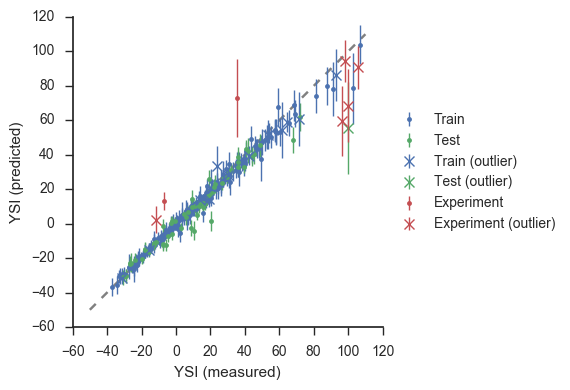

In [9]:
with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(4,4))
    
    ax = fig.add_subplot(111, aspect='equal')

    ax.set_xlim([-60, 120])
    ax.set_ylim([-60, 120])


    #ax.plot(y.values, y_cv_predict, '.')
    #ax.plot(y_test.values, model.predict(X_test.values), 'g.')
    ax.errorbar(y.loc[y.inlier, 'YSI'], y_train_predictions[y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[y.inlier.values].std(1), fmt='.', label='Train', lw=1., color='b')
    ax.errorbar(y_test.loc[y_test.inlier, 'YSI'], y_test_predictions[y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[y_test.inlier.values].std(1), fmt='.', label='Test', lw=1., color='g')

    ax.errorbar(y.loc[~y.inlier, 'YSI'], y_train_predictions[~y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[~y.inlier.values].std(1), fmt='x', label='Train (outlier)', lw=1.,
                markeredgewidth=1, color='b', capsize=0)
    ax.errorbar(y_test.loc[~y_test.inlier, 'YSI'], y_test_predictions[~y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[~y_test.inlier.values].std(1), fmt='x', label='Test (outlier)', lw=1.,
                markeredgewidth=1., color='g', capsize=0)

    ax.errorbar(pruned[inliers], predictions[inliers].mean(1), yerr=1.96*predictions[inliers].std(1),
                fmt='.', lw=1., label='Experiment', color='r', zorder=5)
    ax.errorbar(pruned[~inliers], predictions[~inliers].mean(1), yerr=1.96*predictions[~inliers].std(1),
                fmt='x', lw=1., label='Experiment (outlier)', color='r', zorder=5, markeredgewidth=1., capsize=0)
    #ax.text(molecule_df.YSI.iloc[0]-2, y_exp_pred.mean(1)[0], '*', ha='right', va='center', size=20)
    
    
    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')


    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')
    leg = ax.legend(loc='center left', bbox_to_anchor=(1., .5))
    
    sns.despine()
    
    fig.savefig('old_prediction.svg', transparent=True, bbox_inches='tight', bbox_extra_artists=(leg,))

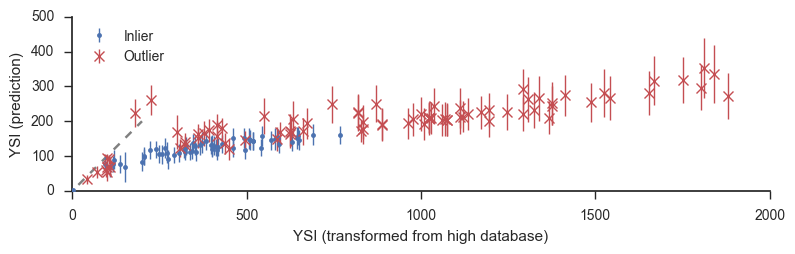

In [10]:
new_descriptors = pd.read_csv('new_mols.tsv', sep='\t', index_col=0).set_index('NAME', drop=True)
new_descriptors = new_descriptors.loc[high.SMILES]
inliers = outlier_model.predict(new_descriptors) == 1
predictions = ensemble_predict(new_descriptors)

with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(9,4))
    
    ax = fig.add_subplot(111, aspect='equal')
    
    ax.errorbar(high.YSIl[inliers], predictions[inliers].mean(1),
                yerr=1.96*predictions[inliers].std(1), fmt='.', lw=1.,
                label='Inlier', color='b', zorder=5)
    
    ax.errorbar(high.YSIl[~inliers], predictions[~inliers].mean(1),
                yerr=1.96*predictions[~inliers].std(1), fmt='x', lw=1.,
                label='Outlier', color='r', zorder=5, markeredgewidth=1., capsize=0)
    
    ax.plot([-50, 200], [-50, 200], '--', zorder=0, color='gray')

    
    ax.set_xlim([0, 2000])
    ax.set_ylim([0, 500])
    
    sns.despine()
    
    ax.set_ylabel('YSI (prediction)')
    ax.set_xlabel('YSI (transformed from high database)')
    
    ax.legend(loc='upper left')
    
    fig.savefig('ysi_high_predictions.svg')

In [11]:
import numpy as np
np.random.seed(0)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Descriptor outlier classification
from sklearn import svm
from sklearn.ensemble import IsolationForest

x_scaler = StandardScaler()
clf = IsolationForest(contamination=0.10)
noutlier_model = Pipeline([
    ('imputer', Imputer()),
    ('filter', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('feature_extraction', PCA(n_components=5)),
    ('outlier_clf', clf),
        ])


noutlier_model.fit(X.values, y.values)
valid_classes = noutlier_model.predict(X)
valid_classes_test = outlier_model.predict(X_test)

y['inlier'] = (valid_classes == 1)
y_test['inlier'] = (valid_classes_test == 1)

pruned = combined_ysi[~combined_ysi.index.isin(low.SMILES)]
pruned = pruned[pruned < low.YSI.max()]

new_descriptors = pd.read_csv('new_mols.tsv', sep='\t', index_col=0).set_index('NAME', drop=True)
new_descriptors = new_descriptors.loc[pruned.index]
inliers = noutlier_model.predict(new_descriptors) == 1

predictions = ensemble_predict(new_descriptors)

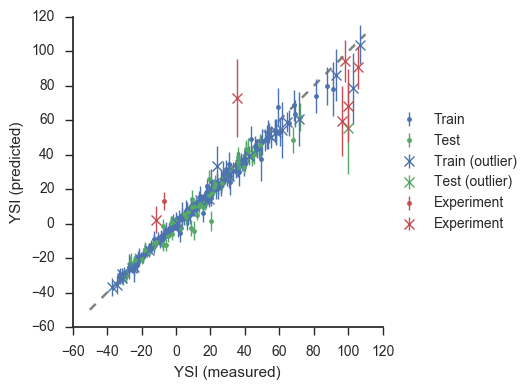

In [12]:
with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(4,4))
    
    ax = fig.add_subplot(111, aspect='equal')

    ax.set_xlim([-60, 120])
    ax.set_ylim([-60, 120])


    #ax.plot(y.values, y_cv_predict, '.')
    #ax.plot(y_test.values, model.predict(X_test.values), 'g.')
    ax.errorbar(y.loc[y.inlier, 'YSI'], y_train_predictions[y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[y.inlier.values].std(1), fmt='.', label='Train', lw=1., color='b')
    ax.errorbar(y_test.loc[y_test.inlier, 'YSI'], y_test_predictions[y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[y_test.inlier.values].std(1), fmt='.', label='Test', lw=1., color='g')

    ax.errorbar(y.loc[~y.inlier, 'YSI'], y_train_predictions[~y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[~y.inlier.values].std(1), fmt='x', label='Train (outlier)', lw=1.,
                markeredgewidth=1, color='b', capsize=0)
    ax.errorbar(y_test.loc[~y_test.inlier, 'YSI'], y_test_predictions[~y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[~y_test.inlier.values].std(1), fmt='x', label='Test (outlier)', lw=1.,
                markeredgewidth=1., color='g', capsize=0)

    ax.errorbar(pruned[inliers], predictions[inliers].mean(1), yerr=1.96*predictions[inliers].std(1),
                fmt='.', lw=1., label='Experiment', color='r', zorder=5)
    ax.errorbar(pruned[~inliers], predictions[~inliers].mean(1), yerr=1.96*predictions[~inliers].std(1),
                fmt='x', lw=1., label='Experiment', color='r', zorder=5, markeredgewidth=1., capsize=0)
    #ax.text(molecule_df.YSI.iloc[0]-2, y_exp_pred.mean(1)[0], '*', ha='right', va='center', size=20)
    
    
    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')


    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')
    
    leg = ax.legend(loc='center left', bbox_to_anchor=(1., .5))
    
    sns.despine()
    
    fig.savefig('new_prediction.svg', transparent=True, bbox_inches='tight', bbox_extra_artists=(leg,))